TBC

In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [2]:
import os
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [3]:
os.chdir('..')
# os.chdir('drive/My Drive/Colab Notebooks/Github/fashion-recommendations') 

In [4]:
from fashion_recommendations.metrics.average_precision import mapk

In [5]:
pd.options.display.max_columns = None

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [7]:
train_set_orig = pd.read_csv('data/splits/train_subset.tsv', sep='\t', dtype={'article_id': str})
print(train_set_orig.shape)
train_set_orig.head()

(588758, 5)


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2
2,2018-09-20,016d8f0519d9e0572b3abebeab87408bad7a5c3a284016...,0650193004,0.050831,1
3,2018-09-20,016d8f0519d9e0572b3abebeab87408bad7a5c3a284016...,0527687006,0.101678,1
4,2018-09-20,02bfe1a5248beb9cd28ad4ac630a6d75e78d9a3e14551a...,0668767002,0.016932,2


In [8]:
test_set = pd.read_csv('data/splits/test_subset.tsv', sep='\t', dtype={'article_id': str})
print(test_set.shape)
test_set.head()

(32995, 5)


,t_dat,customer_id,article_id,price,sales_channel_id
0,2020-09-15,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007,0.061000,2
1,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0778745010,0.033881,2
2,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0778745010,0.033881,2
3,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0610776105,0.008458,2
4,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0929745001,0.050831,2


Only include articles bought after 2020-01:

In [9]:
train_set_orig['t_dat'] = pd.to_datetime(train_set_orig['t_dat'])

In [11]:
article_id_to_keep = train_set_orig[train_set_orig['t_dat'] > '2020-01-01']['article_id'].unique()

In [12]:
print(train_set_orig.shape)
train_set_orig = train_set_orig.copy()[train_set_orig['article_id'].isin(article_id_to_keep)]
print(train_set_orig.shape)

(588758, 5)
(395219, 5)


In [13]:
customers = pd.read_csv('data/customers.csv')
print(customers.shape)
customers.head()

(1371980, 7)


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [14]:
customers.isnull().sum() / customers.shape[0]

customer_id               0.000000
FN                        0.652378
Active                    0.661508
club_member_status        0.004418
fashion_news_frequency    0.011669
age                       0.011561
postal_code               0.000000
dtype: float64

In [15]:
customers[['FN', 'Active']] = customers[['FN', 'Active']].fillna(0)

In [16]:
customers['club_member_status'] = customers['club_member_status'].str.lower().str.replace('-', '_').str.replace(' ', '_').fillna('missing')

In [17]:
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].str.lower().str.replace('-', '_').str.replace(' ', '_').fillna('missing')

In [18]:
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].replace('none', 'missing')

In [19]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,0.0,active,missing,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.0,0.0,active,missing,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,0.0,active,missing,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.0,0.0,active,missing,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,active,regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


### Map `customer_id` and `article_id` to indices

Test set doesn't include anyone not in training set

In [20]:
unique_customers_df = train_set_orig[['customer_id']].drop_duplicates().reset_index(drop=True)

customer_id_to_idx = dict(
    zip(
        unique_customers_df['customer_id'],
        unique_customers_df.index
    )
)

len(customer_id_to_idx)

9122

In [21]:
articles_df = pd.read_csv(
    'data/articles.csv', 
    dtype={'article_id': str}, 
#     usecols=['article_id', 'prod_name', 'product_type_name', 'product_group_name', 'detail_desc']
)
print(articles_df.shape)
articles_df.head()

(105542, 25)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,0108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,0110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,Light,9,White,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [22]:
articles_df['product_group_no'] = articles_df['product_group_name'].copy()

In [23]:
CATEGORICAL_FEATURES = [
    'product_code', 
    'product_type_no', 
    'product_group_no', 
    'graphical_appearance_no', 
    'colour_group_code', 
    'perceived_colour_value_id', 
    'perceived_colour_master_id', 
    'department_no', 
    'index_code', 
    'index_group_no', 
    'section_no', 
    'garment_group_no'
]

In [24]:
cat_code_to_indices = {}

for cat in CATEGORICAL_FEATURES:
    cat_code_to_indices[cat] = {v: k for k, v in dict(enumerate(articles_df[cat].unique())).items()}

In [25]:
for cat in CATEGORICAL_FEATURES:
    articles_df[cat] = articles_df[cat].map(cat_code_to_indices[cat])

In [26]:
articles_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,product_group_no
0,0108775015,0,Strap top,0,Vest top,Garment Upper body,0,Solid,0,Black,0,Dark,0,Black,0,Jersey Basic,0,Ladieswear,0,Ladieswear,0,Womens Everyday Basics,0,Jersey Basic,Jersey top with narrow shoulder straps.,0
1,0108775044,0,Strap top,0,Vest top,Garment Upper body,0,Solid,1,White,1,Light,1,White,0,Jersey Basic,0,Ladieswear,0,Ladieswear,0,Womens Everyday Basics,0,Jersey Basic,Jersey top with narrow shoulder straps.,0
2,0108775051,0,Strap top (1),0,Vest top,Garment Upper body,1,Stripe,2,Off White,2,Dusty Light,1,White,0,Jersey Basic,0,Ladieswear,0,Ladieswear,0,Womens Everyday Basics,0,Jersey Basic,Jersey top with narrow shoulder straps.,0
3,0110065001,1,OP T-shirt (Idro),1,Bra,Underwear,0,Solid,0,Black,0,Dark,0,Black,1,Clean Lingerie,1,Lingeries/Tights,0,Ladieswear,1,Womens Lingerie,1,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde...",1
4,0110065002,1,OP T-shirt (Idro),1,Bra,Underwear,0,Solid,1,White,1,Light,1,White,1,Clean Lingerie,1,Lingeries/Tights,0,Ladieswear,1,Womens Lingerie,1,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde...",1


In [27]:
article_id_to_keep

array(['0809411002', '0809521003', '0802461007', ..., '0946763001',
       '0932383001', '0917296003'], dtype=object)

In [31]:
articles_df.shape

(105542, 26)

In [30]:
articles_df[articles_df['article_id'].isin(article_id_to_keep)].shape

(28709, 26)

In [33]:
articles_df_filtered = articles_df.copy()[articles_df['article_id'].isin(article_id_to_keep)]
articles_df_filtered.reset_index(drop=True, inplace=True)

In [35]:
article_id_to_idx = dict(
    zip(
        articles_df_filtered['article_id'],
        articles_df_filtered.index
    )
)

In [36]:
articles_df_filtered['article_id_idx'] = articles_df_filtered['article_id'].map(article_id_to_idx)

In [37]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,0.0,active,missing,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.0,0.0,active,missing,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,0.0,active,missing,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.0,0.0,active,missing,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,active,regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [38]:
customers_cat_code_to_indices = {}

for cat in ['club_member_status', 'fashion_news_frequency', 'postal_code']:
    customers_cat_code_to_indices[cat] = {v: k for k, v in dict(enumerate(customers[cat].unique())).items()}

In [39]:
for cat in ['club_member_status', 'fashion_news_frequency', 'postal_code']:
    customers[cat] = customers[cat].map(customers_cat_code_to_indices[cat])

In [40]:
customers['customer_id_idx'] = customers['customer_id'].map(customer_id_to_idx)

In [41]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,customer_id_idx
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,0.0,0,0,49.0,0,NaN
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.0,0.0,0,0,25.0,1,NaN
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,0.0,0,0,24.0,2,8065.0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.0,0.0,0,0,54.0,3,NaN
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,0,1,52.0,4,NaN


In [42]:
train_set_orig['customer_id_idx'] = train_set_orig['customer_id'].map(customer_id_to_idx)
train_set_orig['article_id_idx'] = train_set_orig['article_id'].map(article_id_to_idx)

train_set_orig.head()

,t_dat,customer_id,article_id,price,sales_channel_id,customer_id_idx,article_id_idx
10,2018-09-20,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0564358010,0.033441,2,0,1810
17,2018-09-20,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0575347003,0.013373,2,0,2100
27,2018-09-20,03126e45c08e82cd192b32cbddbeba63387e11e5531059...,0573652001,0.033881,2,1,2072
40,2018-09-20,08e5ec1f652c85fc59be204b60f262b6d1f45e4ce11872...,0573937001,0.032186,2,2,2081
43,2018-09-20,09bca14258b7e9b9ee968adffe54d45c1e370e8ed79a22...,0579541001,0.016932,1,3,2175


Merge article features

In [43]:
train_set_orig = train_set_orig.merge(
    articles_df_filtered[['article_id_idx'] + CATEGORICAL_FEATURES], 
    on='article_id_idx', 
    how='inner'
)

In [44]:
train_set_orig.head()

,t_dat,customer_id,article_id,price,sales_channel_id,customer_id_idx,article_id_idx,product_code,product_type_no,product_group_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no
0,2018-09-20,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0564358010,0.033441,2,0,1810,5169,5,0,3,7,2,3,70,3,2,27,9
1,2018-11-11,250f3b498d9db02c2e63ff0a51d8891b0ae77e2bdf62e0...,0564358010,0.030169,2,151,1810,5169,5,0,3,7,2,3,70,3,2,27,9
2,2018-11-23,093d9f68df61795d0e5193cd6e08d6f2c02b3054161a7f...,0564358010,0.027102,1,940,1810,5169,5,0,3,7,2,3,70,3,2,27,9
3,2018-11-26,32063e800a552f2feb957c4e5b442e134273db2eb3af5b...,0564358010,0.033881,2,3041,1810,5169,5,0,3,7,2,3,70,3,2,27,9
4,2019-08-14,9570fb7ef5d4f30e34473c18bb6630b28df1f0933bed6c...,0564358010,0.030492,1,5756,1810,5169,5,0,3,7,2,3,70,3,2,27,9


In [45]:
train_set_orig.drop(columns=['price', 'sales_channel_id'], inplace=True)

Merge customer features

In [46]:
train_set_orig.shape

(395219, 17)

In [48]:
train_set_orig = train_set_orig.merge(
    customers.drop(columns='customer_id'),
    on='customer_id_idx'
)

In [49]:
train_set_orig.head()

,t_dat,customer_id,article_id,customer_id_idx,article_id_idx,product_code,product_type_no,product_group_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,2018-09-20,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0564358010,0,1810,5169,5,0,3,7,2,3,70,3,2,27,9,0.0,0.0,0,0,46.0,13518
1,2018-09-20,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0575347003,0,2100,6223,3,2,0,0,0,0,66,3,2,4,2,0.0,0.0,0,0,46.0,13518
2,2019-11-24,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0562245001,0,1722,4956,7,3,0,0,0,0,48,0,0,21,11,0.0,0.0,0,0,46.0,13518
3,2019-11-24,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0664405002,0,4125,16466,17,4,0,0,0,0,19,4,0,12,4,0.0,0.0,0,0,46.0,13518
4,2019-12-20,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0664405002,0,4125,16466,17,4,0,0,0,0,19,4,0,12,4,0.0,0.0,0,0,46.0,13518


### Create example age and time-related features

In [50]:
train_set_orig['t_dat'] = pd.to_datetime(train_set_orig['t_dat'])

In [51]:
end = train_set_orig['t_dat'].max()
endm1 = end - datetime.timedelta(days=7)

endm1, end

(Timestamp('2020-09-07 00:00:00'), Timestamp('2020-09-14 00:00:00'))

In [52]:
train_set_orig['example_age'] = (end - train_set_orig['t_dat']).dt.days

<AxesSubplot:>

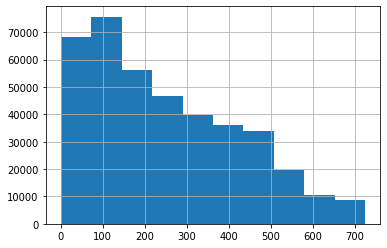

In [53]:
train_set_orig['example_age'].hist()

In [54]:
train_set_orig['t_dat_quarter'] = train_set_orig['t_dat'].dt.quarter

In [55]:
train_set_orig = pd.get_dummies(train_set_orig, columns=['t_dat_quarter'])

In [56]:
train_set_orig.head()

,t_dat,customer_id,article_id,customer_id_idx,article_id_idx,product_code,product_type_no,product_group_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,example_age,t_dat_quarter_1,t_dat_quarter_2,t_dat_quarter_3,t_dat_quarter_4
0,2018-09-20,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0564358010,0,1810,5169,5,0,3,7,2,3,70,3,2,27,9,0.0,0.0,0,0,46.0,13518,725,0,0,1,0
1,2018-09-20,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0575347003,0,2100,6223,3,2,0,0,0,0,66,3,2,4,2,0.0,0.0,0,0,46.0,13518,725,0,0,1,0
2,2019-11-24,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0562245001,0,1722,4956,7,3,0,0,0,0,48,0,0,21,11,0.0,0.0,0,0,46.0,13518,295,0,0,0,1
3,2019-11-24,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0664405002,0,4125,16466,17,4,0,0,0,0,19,4,0,12,4,0.0,0.0,0,0,46.0,13518,295,0,0,0,1
4,2019-12-20,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0664405002,0,4125,16466,17,4,0,0,0,0,19,4,0,12,4,0.0,0.0,0,0,46.0,13518,269,0,0,0,1


### Create development set

In [57]:
# Remove customers from dev set who are not in the new training set
customers_to_remove = (
    set(train_set_orig[train_set_orig['t_dat'] >= endm1]['customer_id']) - 
    set(train_set_orig[train_set_orig['t_dat'] < endm1]['customer_id'])
)

In [58]:
len(customers_to_remove)

70

In [59]:
train_set = train_set_orig.copy()[train_set_orig['t_dat'] < endm1]

dev_set = train_set_orig.copy()[train_set_orig['t_dat'] >= endm1]

train_set.shape, dev_set.shape

((386856, 28), (8363, 28))

In [60]:
dev_set = dev_set.copy()[~dev_set['customer_id'].isin(customers_to_remove)]
print(dev_set.shape)
dev_set.head()

(8099, 28)


,t_dat,customer_id,article_id,customer_id_idx,article_id_idx,product_code,product_type_no,product_group_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,example_age,t_dat_quarter_1,t_dat_quarter_2,t_dat_quarter_3,t_dat_quarter_4
143,2020-09-12,250f3b498d9db02c2e63ff0a51d8891b0ae77e2bdf62e0...,0599580038,151,2559,8578,20,10,0,26,4,7,21,1,0,14,8,1.0,1.0,0,1,49.0,30927,2,0,0,1,0
149,2020-09-12,250f3b498d9db02c2e63ff0a51d8891b0ae77e2bdf62e0...,0806225008,151,14747,34507,19,10,0,26,4,7,21,1,0,14,8,1.0,1.0,0,1,49.0,30927,2,0,0,1,0
345,2020-09-09,86e37e621fbf064a32eaddecfbbcc43a86b64b20811f00...,0820613001,2132,16923,36313,6,0,0,4,3,2,136,0,0,21,3,0.0,0.0,0,0,34.0,284419,5,0,0,1,0
433,2020-09-09,86e37e621fbf064a32eaddecfbbcc43a86b64b20811f00...,0456163087,2132,691,867,14,0,0,4,3,8,0,0,0,0,0,0.0,0.0,0,0,34.0,284419,5,0,0,1,0
612,2020-09-10,ad17ed12c7dfceb9989fdbc8733eb3b4215344606d7ea2...,0863620002,2093,22702,41011,6,0,1,4,3,2,0,0,0,0,0,0.0,0.0,0,0,55.0,170664,4,0,0,1,0


In [61]:
dev_set_by_customer = dev_set.groupby('customer_id').apply(lambda x: list(x['article_id_idx'])).reset_index().rename(columns={0: 'article_id_idx'})
dev_set_by_customer.head()

,customer_id,article_id_idx
0,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,[27260]
1,0054c50274d19af58d53ef3ce0c004bea446c80bd51cf2...,"[10447, 10779, 1903]"
2,00639e775b90554156986100685c4d408723c77e411e37...,"[26236, 26236, 26239]"
3,00798bd464457d23d6af401715fe32d5c676ad9ee4010d...,[28006]
4,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,"[616, 5368, 5368, 25350, 25350, 23305, 23305, ..."


In [62]:
customer_id_idx_ordered = dev_set_by_customer['customer_id'].map(customer_id_to_idx).tolist()

In [63]:
dev_actuals = dev_set_by_customer['article_id_idx'].to_list()

### Format data

Since all the users in the test said are included in training we utilise the full training set.

In [64]:
train_set.head()

,t_dat,customer_id,article_id,customer_id_idx,article_id_idx,product_code,product_type_no,product_group_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,example_age,t_dat_quarter_1,t_dat_quarter_2,t_dat_quarter_3,t_dat_quarter_4
0,2018-09-20,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0564358010,0,1810,5169,5,0,3,7,2,3,70,3,2,27,9,0.0,0.0,0,0,46.0,13518,725,0,0,1,0
1,2018-09-20,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0575347003,0,2100,6223,3,2,0,0,0,0,66,3,2,4,2,0.0,0.0,0,0,46.0,13518,725,0,0,1,0
2,2019-11-24,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0562245001,0,1722,4956,7,3,0,0,0,0,48,0,0,21,11,0.0,0.0,0,0,46.0,13518,295,0,0,0,1
3,2019-11-24,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0664405002,0,4125,16466,17,4,0,0,0,0,19,4,0,12,4,0.0,0.0,0,0,46.0,13518,295,0,0,0,1
4,2019-12-20,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0664405002,0,4125,16466,17,4,0,0,0,0,19,4,0,12,4,0.0,0.0,0,0,46.0,13518,269,0,0,0,1


In [65]:
endm1

Timestamp('2020-09-07 00:00:00')

In [66]:
# # Latest transactions only
# train_set = train_set.copy()[train_set['t_dat'] > endm1 - datetime.timedelta(days=7*52)]

In [67]:
train_set.shape

(386856, 28)

In [68]:
# train_set_processed = train_set.copy().drop(columns=['t_dat']).drop_duplicates()
train_set_processed = train_set.copy()
train_set_processed.shape

(386856, 28)

In [69]:
train_set_processed.head()

,t_dat,customer_id,article_id,customer_id_idx,article_id_idx,product_code,product_type_no,product_group_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,example_age,t_dat_quarter_1,t_dat_quarter_2,t_dat_quarter_3,t_dat_quarter_4
0,2018-09-20,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0564358010,0,1810,5169,5,0,3,7,2,3,70,3,2,27,9,0.0,0.0,0,0,46.0,13518,725,0,0,1,0
1,2018-09-20,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0575347003,0,2100,6223,3,2,0,0,0,0,66,3,2,4,2,0.0,0.0,0,0,46.0,13518,725,0,0,1,0
2,2019-11-24,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0562245001,0,1722,4956,7,3,0,0,0,0,48,0,0,21,11,0.0,0.0,0,0,46.0,13518,295,0,0,0,1
3,2019-11-24,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0664405002,0,4125,16466,17,4,0,0,0,0,19,4,0,12,4,0.0,0.0,0,0,46.0,13518,295,0,0,0,1
4,2019-12-20,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0664405002,0,4125,16466,17,4,0,0,0,0,19,4,0,12,4,0.0,0.0,0,0,46.0,13518,269,0,0,0,1


Create another dev split to measure classification loss during training

In [70]:
from sklearn.model_selection import train_test_split

In [71]:
training_data_full = train_set_processed.copy()
del train_set_processed

In [72]:
training_data_full, dev_data_full = train_test_split(training_data_full, test_size=0.3)

In [73]:
from sklearn.impute import SimpleImputer

In [74]:
imp_mean = SimpleImputer()

In [75]:
imp_mean.fit(training_data_full['age'].values.reshape(-1, 1))

SimpleImputer()

In [76]:
training_data_full['age'] = imp_mean.transform(training_data_full['age'].values.reshape(-1, 1))
dev_data_full['age'] = imp_mean.transform(dev_data_full['age'].values.reshape(-1, 1))

In [77]:
from sklearn.preprocessing import MinMaxScaler

In [78]:
scaler = MinMaxScaler()

In [79]:
scaler.fit(training_data_full[['age', 'example_age']])

MinMaxScaler()

In [80]:
training_data_full[['age', 'example_age']] = scaler.transform(training_data_full[['age', 'example_age']])
dev_data_full[['age', 'example_age']] = scaler.transform(dev_data_full[['age', 'example_age']])

In [81]:
training_data_full.head()

,t_dat,customer_id,article_id,customer_id_idx,article_id_idx,product_code,product_type_no,product_group_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,example_age,t_dat_quarter_1,t_dat_quarter_2,t_dat_quarter_3,t_dat_quarter_4
100780,2020-06-21,054652b71a279ee6233c6f0f5575df1ec246a399027494...,0399223033,4931,469,548,7,3,7,8,2,4,74,7,4,26,5,1.0,1.0,0,1,0.281690,21167,0.107392,0,1,0,0
215404,2019-09-22,34f92fee0612463cd8cf541afd096ab1a801ff9c0cb0e2...,0563519016,7247,1773,5095,5,0,0,11,0,7,0,0,0,0,0,1.0,1.0,0,1,0.549296,12290,0.488145,0,0,1,0
56234,2019-12-01,19e800c505e732a7e6b2f3af7f0dc09403992de6d5a00a...,0550021002,3654,1468,4048,56,4,0,15,4,10,38,4,0,6,4,1.0,1.0,0,1,0.056338,100555,0.390516,0,0,0,1
292749,2019-02-06,185d49abce8943f850a3e9f1cec83932ac81d522a96825...,0636420001,3620,3432,12784,23,3,2,8,0,4,120,0,0,21,15,0.0,0.0,0,0,0.647887,95694,0.806137,1,0,0,0
324293,2020-04-02,438db84efe382a2e0316ae08fa95e4d2e143dbd94de5b2...,0877461001,1510,24626,42636,62,0,2,41,2,15,182,0,0,28,17,1.0,1.0,0,1,0.394366,70361,0.218968,0,1,0,0


In [82]:
NUMERIC_FEATURES = [
    'FN', 
    'Active', 
    'age', 
    'example_age', 
    't_dat_quarter_1', 
    't_dat_quarter_2', 
    't_dat_quarter_3', 
    't_dat_quarter_4'
]

In [83]:
class PurchasesDatasetWithArticleFeatures(Dataset):

    def __init__(self, df):
        self.customer_id_idx = df['customer_id_idx'].values
        
        self.product_code = df['product_code'].values
        self.product_type_no = df['product_type_no'].values
        self.product_group_no = df['product_group_no'].values
        self.graphical_appearance_no = df['graphical_appearance_no'].values
        self.colour_group_code = df['colour_group_code'].values
        self.perceived_colour_value_id = df['perceived_colour_value_id'].values
        self.perceived_colour_master_id = df['perceived_colour_master_id'].values
        self.department_no = df['department_no'].values
        self.index_code = df['index_code'].values
        self.index_group_no = df['index_group_no'].values
        self.section_no = df['section_no'].values
        self.garment_group_no = df['garment_group_no'].values
        
        self.club_member_status = df['club_member_status'].values
        self.fashion_news_frequency = df['fashion_news_frequency'].values
        self.postal_code = df['postal_code'].values
        self.numeric_features = df[NUMERIC_FEATURES].values
        
        self.purchased = df['article_id_idx'].values

    def __len__(self):
        return self.customer_id_idx.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        return (
            self.customer_id_idx[idx],
            self.product_code[idx],
            self.product_type_no[idx],
            self.product_group_no[idx],
            self.graphical_appearance_no[idx],
            self.colour_group_code[idx],
            self.perceived_colour_value_id[idx],
            self.perceived_colour_master_id[idx],
            self.department_no[idx],
            self.index_code[idx],
            self.index_group_no[idx],
            self.section_no[idx],
            self.garment_group_no[idx],
            self.club_member_status[idx],
            self.fashion_news_frequency[idx],
            self.postal_code[idx],
            self.numeric_features[idx],
            self.purchased[idx]
        )

In [84]:
train_dataset = PurchasesDatasetWithArticleFeatures(training_data_full)
dev_dataset = PurchasesDatasetWithArticleFeatures(dev_data_full)

In [85]:
BATCH_SIZE = 2048

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)  
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=True)  

In [86]:
# # Selecting a subset of data
# subset = torch.utils.data.Subset(train_dataset, [1])

# train_loader = DataLoader(subset, batch_size=BATCH_SIZE)  

In [95]:
class FashionRecV2(nn.Module):

    def __init__(self, embedding_dim):
        super(FashionRecV2, self).__init__()
        
        # Embeddings
        self.user_embeddings = nn.Embedding(num_embeddings=len(customer_id_to_idx), embedding_dim=embedding_dim)        
        self.product_code_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['product_code']), embedding_dim=embedding_dim)
        self.product_type_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['product_type_no']), embedding_dim=embedding_dim)
        self.product_group_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['product_group_no']), embedding_dim=embedding_dim)
        self.graphical_appearance_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['graphical_appearance_no']), embedding_dim=embedding_dim)
        self.colour_group_code_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['colour_group_code']), embedding_dim=embedding_dim)
        self.perceived_colour_value_id_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['perceived_colour_value_id']), embedding_dim=embedding_dim)
        self.perceived_colour_master_id_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['perceived_colour_master_id']), embedding_dim=embedding_dim)
        self.department_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['department_no']), embedding_dim=embedding_dim)
        self.index_code_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['index_code']), embedding_dim=embedding_dim)
        self.index_group_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['index_group_no']), embedding_dim=embedding_dim)
        self.section_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['section_no']), embedding_dim=embedding_dim)
        self.garment_group_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['garment_group_no']), embedding_dim=embedding_dim)
        
        self.club_member_status_embeddings = nn.Embedding(num_embeddings=len(customers_cat_code_to_indices['club_member_status']), embedding_dim=embedding_dim)
        self.fashion_news_frequency_embeddings = nn.Embedding(num_embeddings=len(customers_cat_code_to_indices['fashion_news_frequency']), embedding_dim=embedding_dim)
        self.postal_code_embeddings = nn.Embedding(num_embeddings=len(customers_cat_code_to_indices['postal_code']), embedding_dim=embedding_dim)

        # Initialise embeddings
        torch.nn.init.xavier_uniform_(self.user_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.product_code_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.product_type_no_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.product_group_no_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.graphical_appearance_no_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.colour_group_code_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.perceived_colour_value_id_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.perceived_colour_master_id_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.department_no_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.index_code_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.index_group_no_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.section_no_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.garment_group_no_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.club_member_status_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.fashion_news_frequency_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.postal_code_embeddings.weight)
        
        # FC layers
        self.fc_1 = nn.Linear(in_features=embedding_dim*16+len(NUMERIC_FEATURES), out_features=500)            
        self.fc_2 = nn.Linear(in_features=500, out_features=250)
        # self.fc_3 = nn.Linear(in_features=500, out_features=250)        
        self.fc_3 = nn.Linear(in_features=250, out_features=len(article_id_to_idx))
        
        # Activation functions
        self.relu = nn.ReLU()        
        
        # Dropout
        self.dropout = nn.Dropout(0.2)
        
    def forward(
        self, 
        user_id, 
        product_code, 
        product_type_no, 
        product_group_no, 
        graphical_appearance_no, 
        colour_group_code, 
        perceived_colour_value_id, 
        perceived_colour_master_id, 
        department_no, 
        index_code, 
        index_group_no, 
        section_no, 
        garment_group_no,
        club_member_status,
        fashion_news_frequency,
        postal_code,
        numeric_features,
    ):

        user_emb = self.user_embeddings(user_id)
        product_code_emb = self.product_code_embeddings(product_code)
        product_type_no_emb = self.product_type_no_embeddings(product_type_no)
        product_group_no_emb = self.product_group_no_embeddings(product_group_no)
        graphical_appearance_no_emb = self.graphical_appearance_no_embeddings(graphical_appearance_no)
        colour_group_code_emb = self.colour_group_code_embeddings(colour_group_code)
        perceived_colour_value_id_emb = self.perceived_colour_value_id_embeddings(perceived_colour_value_id)
        perceived_colour_master_id_emb = self.perceived_colour_master_id_embeddings(perceived_colour_master_id)
        department_no_emb = self.department_no_embeddings(department_no)
        index_code_emb = self.index_code_embeddings(index_code)
        index_group_no_emb = self.index_group_no_embeddings(index_group_no)
        section_no_emb = self.section_no_embeddings(section_no)
        garment_group_no_emb = self.garment_group_no_embeddings(garment_group_no)
        
        club_member_status_emb = self.club_member_status_embeddings(club_member_status)
        fashion_news_frequency_emb = self.fashion_news_frequency_embeddings(fashion_news_frequency)
        postal_code_emb = self.postal_code_embeddings(postal_code)
              
        concatenated_emb = torch.concat(
            [
                user_emb, 
                product_code_emb,
                product_type_no_emb,
                product_group_no_emb,
                graphical_appearance_no_emb,
                colour_group_code_emb,
                perceived_colour_value_id_emb,
                perceived_colour_master_id_emb,
                department_no_emb,
                index_code_emb,
                index_group_no_emb,
                section_no_emb,
                garment_group_no_emb,
                club_member_status_emb,
                fashion_news_frequency_emb,
                postal_code_emb,
                numeric_features
            ], 
            dim=1
        )
        
        x = self.fc_1(concatenated_emb)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc_2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc_3(x)

        return x

In [106]:
fashion_rec_v2 = FashionRecV2(embedding_dim=8)

In [107]:
fashion_rec_v2.to(device)

FashionRecV2(
  (user_embeddings): Embedding(9122, 8)
  (product_code_embeddings): Embedding(47224, 8)
  (product_type_no_embeddings): Embedding(132, 8)
  (product_group_no_embeddings): Embedding(19, 8)
  (graphical_appearance_no_embeddings): Embedding(30, 8)
  (colour_group_code_embeddings): Embedding(50, 8)
  (perceived_colour_value_id_embeddings): Embedding(8, 8)
  (perceived_colour_master_id_embeddings): Embedding(20, 8)
  (department_no_embeddings): Embedding(299, 8)
  (index_code_embeddings): Embedding(10, 8)
  (index_group_no_embeddings): Embedding(5, 8)
  (section_no_embeddings): Embedding(57, 8)
  (garment_group_no_embeddings): Embedding(21, 8)
  (club_member_status_embeddings): Embedding(4, 8)
  (fashion_news_frequency_embeddings): Embedding(3, 8)
  (postal_code_embeddings): Embedding(352899, 8)
  (fc_1): Linear(in_features=136, out_features=500, bias=True)
  (fc_2): Linear(in_features=500, out_features=250, bias=True)
  (fc_3): Linear(in_features=250, out_features=28709, bia

In [108]:
# fashion_rec_v2(torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), )

In [109]:
optimizer = torch.optim.Adam(params=fashion_rec_v2.parameters(), lr=0.001)

Switched to BCELoss instead of weighted MSE. Had more success with this.

In [110]:
criterion = nn.CrossEntropyLoss()

In [111]:
MAX_EPOCHS = 5
training_losses = []
dev_losses = []

for epoch in range(MAX_EPOCHS):
    
    for data in tqdm(train_loader):
        
        user_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = data
        
        user_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = (
            user_id.to(device), 
            product_code.to(device), 
            product_type_no.to(device), 
            product_group_no.to(device), 
            graphical_appearance_no.to(device), 
            colour_group_code.to(device), 
            perceived_colour_value_id.to(device), 
            perceived_colour_master_id.to(device), 
            department_no.to(device), 
            index_code.to(device), 
            index_group_no.to(device), 
            section_no.to(device), 
            garment_group_no.to(device), 
            club_member_status.to(device), 
            fashion_news_frequency.to(device), 
            postal_code.to(device), 
            numeric_features.to(device),
            label.to(device)
        )    

        optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

        pred = fashion_rec_v2(
            user_id, 
            product_code, 
            product_type_no, 
            product_group_no, 
            graphical_appearance_no, 
            colour_group_code, 
            perceived_colour_value_id, 
            perceived_colour_master_id, 
            department_no, 
            index_code, 
            index_group_no, 
            section_no, 
            garment_group_no,
            club_member_status,
            fashion_news_frequency,
            postal_code,
            numeric_features.float()
        )

        loss = criterion(pred, label)

        loss.backward()  
        
        optimizer.step()
        
    # Compute training loss
    
    total_train_loss = 0

    fashion_rec_v2.eval()

    with torch.no_grad():
        for data in tqdm(DataLoader(train_dataset, batch_size=BATCH_SIZE*4)):
            
            user_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = data

            user_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = (
                user_id.to(device), 
                product_code.to(device), 
                product_type_no.to(device), 
                product_group_no.to(device), 
                graphical_appearance_no.to(device), 
                colour_group_code.to(device), 
                perceived_colour_value_id.to(device), 
                perceived_colour_master_id.to(device), 
                department_no.to(device), 
                index_code.to(device), 
                index_group_no.to(device), 
                section_no.to(device), 
                garment_group_no.to(device), 
                club_member_status.to(device), 
                fashion_news_frequency.to(device), 
                postal_code.to(device), 
                numeric_features.to(device),
                label.to(device)
            )

            pred = fashion_rec_v2(
                user_id, 
                product_code, 
                product_type_no, 
                product_group_no, 
                graphical_appearance_no, 
                colour_group_code, 
                perceived_colour_value_id, 
                perceived_colour_master_id, 
                department_no, 
                index_code, 
                index_group_no, 
                section_no, 
                garment_group_no,
                club_member_status,
                fashion_news_frequency,
                postal_code,
                numeric_features.float()
            )

            loss = nn.CrossEntropyLoss(reduction='sum')(pred, label)

            total_train_loss += loss.item()

        mean_train_loss = total_train_loss / len(train_dataset)

        print(f"Training loss: {mean_train_loss}")
        training_losses.append(mean_train_loss)
    
    # Compute dev loss
    
    total_dev_loss = 0

    with torch.no_grad():
        for data in tqdm(DataLoader(dev_dataset, batch_size=BATCH_SIZE*4)):
            
            user_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = data
        
            user_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = (
                user_id.to(device), 
                product_code.to(device), 
                product_type_no.to(device), 
                product_group_no.to(device), 
                graphical_appearance_no.to(device), 
                colour_group_code.to(device), 
                perceived_colour_value_id.to(device), 
                perceived_colour_master_id.to(device), 
                department_no.to(device), 
                index_code.to(device), 
                index_group_no.to(device), 
                section_no.to(device), 
                garment_group_no.to(device), 
                club_member_status.to(device), 
                fashion_news_frequency.to(device), 
                postal_code.to(device), 
                numeric_features.to(device),
                label.to(device)
            )    

            optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

            pred = fashion_rec_v2(
                user_id, 
                product_code, 
                product_type_no, 
                product_group_no, 
                graphical_appearance_no, 
                colour_group_code, 
                perceived_colour_value_id, 
                perceived_colour_master_id, 
                department_no, 
                index_code, 
                index_group_no, 
                section_no, 
                garment_group_no,
                club_member_status,
                fashion_news_frequency,
                postal_code,
                numeric_features.float()
            )

            loss = nn.CrossEntropyLoss(reduction='sum')(pred, label)

            total_dev_loss += loss.item()

        mean_dev_loss = total_dev_loss / len(dev_dataset)

        print(f"Dev loss: {mean_dev_loss}")
        dev_losses.append(mean_dev_loss)
    
    fashion_rec_v2.train()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:58<00:00,  1.71s/it]


Training loss: 6.310105539605136


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:24<00:00,  1.64s/it]


Dev loss: 6.531109427237262


 15%|█████████████████████████████▌                                                                                                                                                                       | 20/133 [00:27<02:33,  1.36s/it]


KeyboardInterrupt: 

### Test set evaluation

In [79]:
test_set['article_id_idx'] = test_set['article_id'].map(article_id_to_idx)

In [80]:
test_set_by_customer = test_set.groupby('customer_id').apply(lambda x: list(x['article_id_idx'])).reset_index().rename(columns={0: 'article_id_idx'})
test_set_by_customer.head()

,customer_id,article_id_idx
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,[78503]
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[74893, 74893, 24872, 104987, 9801, 9801, 6912..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[92815, 86041]"
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[104211, 17044, 17044, 16024, 29250, 98445, 66..."
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[87467, 99966, 42626, 79834, 97540, 103280, 79..."


In [81]:
test_set.shape

(32995, 6)

In [82]:
test_set.shape[0] * 100 / len(dev_dataset) * 9 / 60

0.17618544494812244

In [83]:
training_data_full.head()

,customer_id_idx,article_id_idx,product_code,product_type_no,product_group_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,purchased
5885273,2847,73698,30654,6,0,0,0,0,0,23,7,4,9,0,0
541363,3804,64918,26815,61,4,17,23,0,2,79,3,2,19,4,0
975898,4791,82204,34722,23,3,0,0,0,0,186,0,0,47,16,0
5642562,5364,75582,31615,38,0,0,0,0,0,209,0,0,32,12,0
2614341,5348,62200,25649,21,1,0,11,5,7,4,1,0,1,1,0


In [84]:
top100_items = (train_set.groupby('article_id_idx')['customer_id'].count() / train_set.shape[0]).sort_values(ascending=False).head(1000).index.tolist()

In [85]:
test_data = test_set_by_customer.copy()[['customer_id']]
test_data['customer_id_idx'] = test_data['customer_id'].map(customer_id_to_idx)
test_data.drop(columns='customer_id', inplace=True)
test_data.head()

,customer_id_idx
0,0
1,4003
2,238
3,3419
4,7876


In [86]:
test_data['join_key'] = 1

In [87]:
top100_items_df = pd.DataFrame({'article_id_idx': top100_items})
top100_items_df['join_key'] = 1
top100_items_df.head()

,article_id_idx,join_key
0,53892,1
1,53893,1
2,1713,1
3,24837,1
4,70221,1


In [88]:
test_data = test_data.merge(top100_items_df, on='join_key').drop('join_key', axis=1)

In [89]:
test_data = test_data.merge(articles_df[['article_id_idx'] + CATEGORICAL_FEATURES], on=['article_id_idx'])

In [90]:
test_data['purchased'] = 999

In [91]:
test_dataset = PurchasesDatasetWithArticleFeatures(test_data)

In [92]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*4)  

In [93]:
test_predictions = []

fashion_rec_v2.eval()

with torch.no_grad():
    for data in tqdm(test_loader):

        user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, label = data

        user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, label = (
            user_id.to(device), 
            item_id.to(device), 
            product_code.to(device), 
            product_type_no.to(device), 
            product_group_no.to(device), 
            graphical_appearance_no.to(device), 
            colour_group_code.to(device), 
            perceived_colour_value_id.to(device), 
            perceived_colour_master_id.to(device), 
            department_no.to(device), 
            index_code.to(device), 
            index_group_no.to(device), 
            section_no.to(device), 
            garment_group_no.to(device), 
            label.to(device)
        )    

        pred = fashion_rec_v2(
            user_id, 
            item_id, 
            product_code, 
            product_type_no, 
            product_group_no, 
            graphical_appearance_no, 
            colour_group_code, 
            perceived_colour_value_id, 
            perceived_colour_master_id, 
            department_no, 
            index_code, 
            index_group_no, 
            section_no, 
            garment_group_no
        )
        
        test_predictions += pred.flatten().tolist()

100%|██████████| 1125/1125 [01:15<00:00, 14.89it/s]


In [94]:
len(test_predictions)

9208000

In [95]:
len(test_dataset)

9208000

In [96]:
test_data['prediction'] = test_predictions

In [97]:
test_data.sort_values(['customer_id_idx', 'prediction'], ascending=False, inplace=True)

In [98]:
test_data_top12 = test_data.groupby('customer_id_idx').head(12).groupby('customer_id_idx').apply(lambda x: list(x['article_id_idx'])).reset_index().rename(columns={0: 'predictions'})
test_data_top12

,customer_id_idx,predictions
0,0,"[46351, 46384, 46425, 16453, 46382, 58491, 464..."
1,1,"[81826, 81825, 81828, 58491, 24836, 4444, 7022..."
2,2,"[53892, 53893, 53894, 53896, 53902, 70221, 702..."
3,3,"[46425, 58584, 46351, 46426, 22465, 16453, 463..."
4,4,"[53892, 53893, 2236, 24837, 70221, 70220, 3091..."
...,...,...
9203,9203,"[53892, 3091, 1713, 24837, 4444, 67522, 53893,..."
9204,9204,"[53892, 24837, 4444, 3091, 1713, 67522, 58491,..."
9205,9205,"[53892, 3091, 4444, 53893, 24837, 70221, 67522..."
9206,9206,"[53892, 3091, 4444, 24837, 67522, 58491, 53893..."


In [99]:
test_set_by_customer['customer_id_idx'] = test_set_by_customer['customer_id'].map(customer_id_to_idx)

In [100]:
test_set_by_customer.head()

,customer_id,article_id_idx,customer_id_idx
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,[78503],0
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[74893, 74893, 24872, 104987, 9801, 9801, 6912...",4003
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[92815, 86041]",238
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[104211, 17044, 17044, 16024, 29250, 98445, 66...",3419
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[87467, 99966, 42626, 79834, 97540, 103280, 79...",7876


In [101]:
test_set_by_customer = test_set_by_customer.merge(test_data_top12, on='customer_id_idx')
test_set_by_customer.head()

,customer_id,article_id_idx,customer_id_idx,predictions
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,[78503],0,"[46351, 46384, 46425, 16453, 46382, 58491, 464..."
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[74893, 74893, 24872, 104987, 9801, 9801, 6912...",4003,"[67522, 24837, 24836, 42626, 17383, 18586, 499..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[92815, 86041]",238,"[58584, 58581, 16453, 16452, 46351, 22465, 464..."
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[104211, 17044, 17044, 16024, 29250, 98445, 66...",3419,"[53892, 46382, 58491, 46386, 70221, 17669, 538..."
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[87467, 99966, 42626, 79834, 97540, 103280, 79...",7876,"[53892, 53893, 2236, 58491, 70221, 3091, 67522..."


In [102]:
predictions = test_set_by_customer['predictions'].to_list()

In [103]:
actuals = test_set_by_customer['article_id_idx'].to_list()

In [104]:
mapk(actuals, predictions, k=12)

0.003228173021132559

In [105]:
test_set_by_customer['predictions'].astype(str).nunique()

9177

In [106]:
test_set_by_customer.shape

(9208, 4)

In [107]:
most_pop_12 = (train_set.groupby('article_id_idx')['customer_id'].count()).sort_values(ascending=False).head(12).index.to_list()
most_pop_12 = set(most_pop_12)
most_pop_12

{1713,
 1714,
 2236,
 3091,
 24836,
 24837,
 42626,
 53892,
 53893,
 58491,
 67522,
 70221}

In [108]:
test_set_by_customer['num_top_12_items'] = test_set_by_customer['predictions'].apply(lambda x: len(set(x).intersection(most_pop_12)))

In [109]:
test_set_by_customer['num_top_12_items'].value_counts().sort_index()

0     1093
1      800
2      810
3     1084
4     1498
5     1314
6     1028
7      770
8      415
9      298
10      93
11       5
Name: num_top_12_items, dtype: int64

Finally we beat our naive baseline, albeit not by much (0.003196 vs. 0.003228). Still a way to go in terms of leaderboard performance.

Interestingly the model is able to do this by producing varied predictions for each customer and doesn't draw frequently from the top-12 most popular items.

Things that seemed to work:
- Limiting articles to ones where there was an observed transaction after 2020. We assume that items before that were removed from the catalog and hence are no longer available
- Added embeddings for article meta-data, concatenating and feed-forward
- Treating as binary classification problem with up to 1,000 negative samples per customer
- When drawing negative samples we only use the reduced set of items
- To avoid making a prediction for all items we only make evaluations for the overall top-1000 items (a naive form of candidate generation)

Possible improvements:
- Most popular items by season?
- User features
- Negative sampling from candidates (top-1000) only
- Way of doing candidate generation within the model (end-to-end)